In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy, scipy.stats
%matplotlib inline
from ipywidgets import interact

//anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
//anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [7]:

PATH_DATA = "/Users/vkobzar/GitHub/uber-tlc-foil-response/uber-trip-data/"
# We will stick to the uber-raw-data-janjune-15.csv file only...
all_pickups = pd.read_csv(PATH_DATA + 'uber-raw-data-janjune-15.csv')
print ('Total number of data points: ', len(all_pickups))
all_pickups[:3] 

Total number of data points:  14270479


,Dispatching_base_num,Pickup_date,Affiliated_base_num,locationID
0,B02617,2015-05-17 09:47:00,B02617,141
1,B02617,2015-05-17 09:47:00,B02617,65
2,B02617,2015-05-17 09:47:00,B02617,100


In [9]:

# isolate the hour information from the full date and add as a column
all_pickups['Pickup_hour'] = all_pickups['Pickup_date'].apply(lambda x: int(x[11:13]))
print ('possible pick-up hours:')
print (sorted(all_pickups.Pickup_hour.unique()))

possible pick-up hours:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]


In [13]:
# let's focus on 2015-01-01 by isolating the day information
all_pickups['Pickup_day'] = all_pickups['Pickup_date'].apply(lambda x: x[0:10])
small_data = all_pickups.groupby('Pickup_day').get_group('2015-01-01') 
print ('number of data points used in the example Bernoulli case: ', len(small_data))
small_data[:3]

number of data points used in the example Bernoulli case:  58045


,Dispatching_base_num,Pickup_date,Affiliated_base_num,locationID,Pickup_hour,Pickup_day
44141,B02598,2015-01-01 15:43:04,B02598,89,15,2015-01-01
44142,B02598,2015-01-01 17:09:38,B02598,148,17,2015-01-01
44143,B02598,2015-01-01 02:10:01,B02789,164,2,2015-01-01


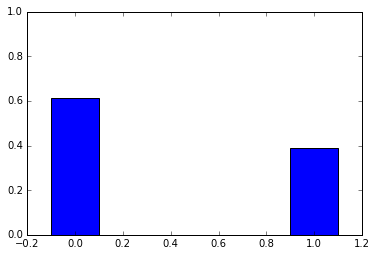

In [14]:

def get_p_before_threshold(threshold, data):
    return len(data[data['Pickup_hour'] < threshold])/float(len(data))

def plot_bernoulli(threshold):
    p = get_p_before_threshold(threshold, small_data)
    plt.bar([-0.1, 0.9], [p, 1 - p], width=0.2)
    plt.ylim(0,1)
    plt.show()
    
# play with the slider to change the threshold hour
interact(plot_bernoulli, threshold=(0, 24, 1));

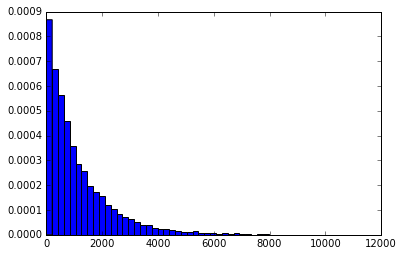

In [15]:
def get_times(loc_ID):
    finding_times = []
    t_current = all_pickups[all_pickups['locationID'] == loc_ID].index[0]
    for t_next in all_pickups[all_pickups['locationID'] == loc_ID].index[1:]:
        finding_times.append(t_next - t_current)
        t_current = t_next
    return finding_times

def plot_geometric(loc_ID):
    times = get_times(loc_ID)
    plt.hist(times, bins=50, normed=True)
    plt.show()
    
interact(plot_geometric, loc_ID=(1, 265, 1));

In [17]:
zones = pd.read_csv(PATH_DATA + 'taxi-zone-lookup.csv').rename(columns={"LocationID": "locationID"})
all_pickups_zones = all_pickups.merge(zones, how='inner', on='locationID')
data = all_pickups_zones.groupby('Pickup_day').get_group('2015-01-01') # again focus on 2015-01-01
data[:3]

,Dispatching_base_num,Pickup_date,Affiliated_base_num,locationID,Pickup_hour,Pickup_day,Borough,Zone
605,B02598,2015-01-01 13:01:14,B02765,141,13,2015-01-01,Manhattan,Lenox Hill West
610,B02598,2015-01-01 13:54:04,B02598,141,13,2015-01-01,Manhattan,Lenox Hill West
611,B02598,2015-01-01 00:24:17,B02598,141,0,2015-01-01,Manhattan,Lenox Hill West


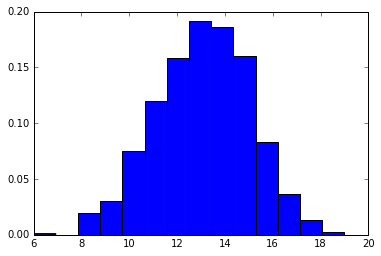

In [18]:
def plot_binomial(n):
    k_observed = []
    for i in range(1000):
        idx = np.random.randint(0, len(data.index), n)
        k_observed.append(len(data.iloc[idx].groupby('Borough').get_group('Manhattan')))
    plt.hist(k_observed, max(k_observed) - min(k_observed) + 1, normed=True)
    plt.show()

interact(plot_binomial, n=(1,40,1));

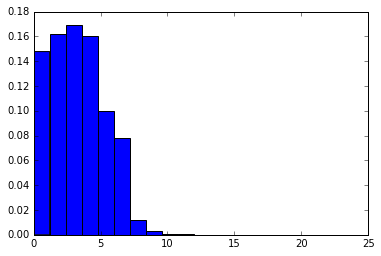

In [19]:
def plot_poisson(n):
    k_experimental = []
    for i in range(1500):
        idx = np.random.randint(0, len(data.index), n)
        data_temp = data.iloc[idx]
        k_experimental.append(len(data_temp[data_temp['Zone'] == 'Greenpoint']))
    plt.hist(k_experimental, normed=True)
    plt.xlim(0, 25)
    plt.show()

interact(plot_poisson, n=(1,400,1));
